In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks


In [ ]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    dat = np.genfromtxt(filename, delimiter=",", skip_header=13, names=True)
    time = dat["Time_s"]
    voltage = dat["Channel_1_V"]
    return time, voltage


def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""

    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).
    peaks, _ = find_peaks(voltage, height=0.5)
    peaks = peaks[voltage[peaks] > 1.0]  # filter peaks by height
    t_pass = time[peaks]
    # refine peak times by quadratic interpolation using neighbouring points
    dt = np.median(np.diff(time))
    # t_pass = np.array(t_pass, dtype=float)
    # t_refined = []
    # for idx in peaks:
    #     if idx <= 0 or idx >= len(time) - 1:
    #         t_refined.append(time[idx])
    #         continue
    #     y1 = voltage[idx - 1]
    #     y0 = voltage[idx]
    #     y2 = voltage[idx + 1]
    #     h = (time[idx + 1] - time[idx - 1]) / 2.0  # half-span around center
    #     denom = 2.0 * (y1 + y2 - 2.0 * y0)
    #     if denom == 0:
    #         t_refined.append(time[idx])
    #         continue
    #     x_offset = h * (y1 - y2) / denom  # vertex offset from center
    #     t_refined.append(time[idx] + x_offset)
    # t_pass = np.array(t_refined)

    # simple conservative uncertainty: one sample spacing / sqrt(12) (uniform sampling)
    t_pass_sigma = np.full(t_pass.shape, dt / np.sqrt(12.0))

    return t_pass, t_pass_sigma

In [ ]:
filename = "C:\\Users\\jeppe\\AppStatLocal\\Project_Folder\\Project\\BallOnIncline\\Ball_data\\BallIncline_1.csv"
time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)
print("Passing times:", timepass)
print("Passing time uncertainties:", timepass_sig)


Passing times: [0.98784 1.13476 1.28886 1.41552 1.53386]
Passing time uncertainties: [5.77350269e-06 5.77350269e-06 5.77350269e-06 5.77350269e-06
 5.77350269e-06]


Text(0, 0.5, 'Voltage (V)')

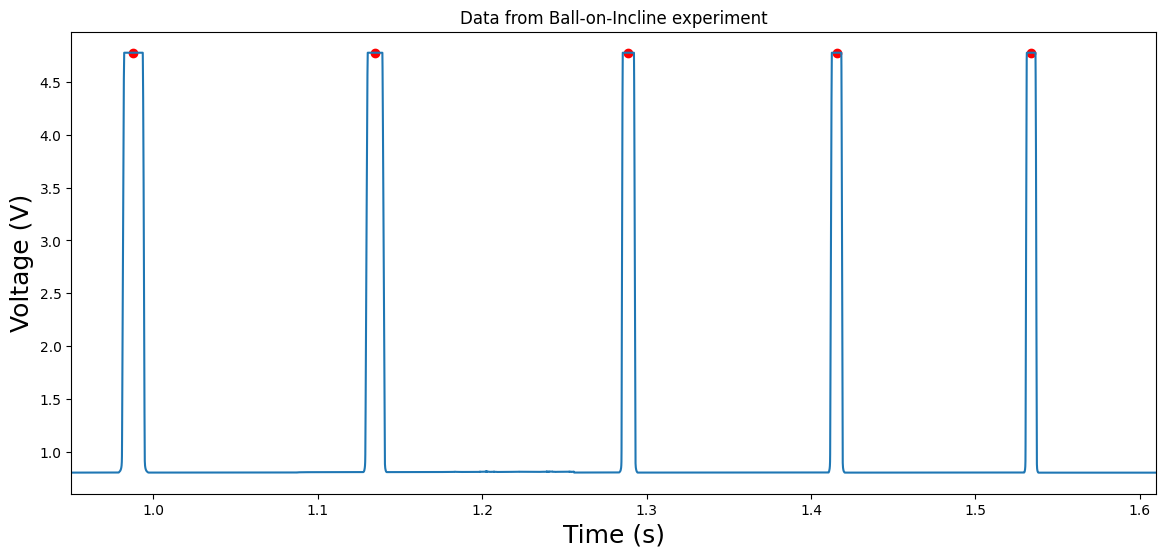

In [ ]:
# Read the data and plot it (possibly with passing times in):
filename = "C:\\Users\\jeppe\\AppStatLocal\\Project_Folder\\Project\\BallOnIncline\\Ball_data\\BallIncline_1.csv"

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(
    timepass, voltage[np.searchsorted(time, timepass)], "ro", label="Detected Passings"
)
ax.plot(time, voltage, label="Voltage Signal")
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_xlim(0.95, 1.61)
ax.set_ylabel("Voltage (V)", fontsize=18)

### Loading gate position data from excel sheet 
Then fitting to obtain the acceleration

In [ ]:
excel_path = "C:\\Users\\jeppe\\AppStatLocal\\Project_Folder\\Project\\BallOnIncline\\Ball_data\\BallOnIncline_Group1_data.xlsx"
incline_length = pd.read_excel(
    excel_path, sheet_name="hældning_længder", skiprows=0, usecols="B:G"
)


In [ ]:
print(incline_length)
print(incline_length["mål_1"].values - incline_length["åbning"].values)

mean_gateposition = []
sigma_gateposition = []
for i in range(4):
    length = np.mean(
        incline_length[f"mål_{i + 1}"].values - incline_length["åbning"].values
    )
    mean_gateposition.append(length)
    sigma = np.std(
        incline_length[f"mål_{i + 1}"].values - incline_length["åbning"].values, ddof=1
    )
    sigma_gateposition.append(sigma)
print("Mean gate positions:", np.array(mean_gateposition) / 100)
print("Sigma gate positions:", np.array(sigma_gateposition) / 100)
# gatepositions = np.array(incline_length.iloc["åbning",:]-incline_length.iloc["mål_1",:])

   åbning  mål_1  mål_2  mål_3  mål_4  mål_5
0   11.85  26.95  38.25  53.30  68.15  83.95
1   11.85  26.95  38.25  53.30  68.20  83.90
2   11.85  26.91  38.29  53.31  68.20  83.90
3   11.75  26.95  38.45  53.40  68.15  84.05
4   11.80  26.90  38.25  53.30  68.10  83.95
[15.1  15.1  15.06 15.2  15.1 ]
Mean gate positions: [0.15112 0.26478 0.41502 0.5634 ]
Sigma gate positions: [0.00052154 0.00126174 0.00085264 0.00041833]


In [ ]:
def acc_func(t, x_0, v_0, a):
    """Position at time t for constant acceleration."""
    return x_0 + v_0 * t + 0.5 * a * t**2


from iminuit import Minuit


def chi2_func(x_data, t_data, sigma_x, x_0, v_0, a):
    chi2 = 0.0
    for i in range(len(x_data)):
        x_model = acc_func(t_data[i], x_0, v_0, a)
        chi2 += ((x_data[i] - x_model) / sigma_x[i]) ** 2
    return chi2


# Prepare data arrays (do not overwrite the name 'chi2' with a float)
x_data_arr = np.array(mean_gateposition) / 100  # convert cm to m
t_data_arr = np.array(timepass)
sigma_arr = np.array(sigma_gateposition) / 100  # convert cm to m


# Wrapper callable for Minuit that only depends on the fit parameters
def chi2_minuit(x_0, v_0, a):
    return chi2_func(x_data_arr, t_data_arr, sigma_arr, x_0, v_0, a)


# Initialize Minuit with the callable and initial guesses
m = Minuit(chi2_minuit, x_0=0.0, v_0=0.0, a=9.81)
m.errordef = Minuit.LEAST_SQUARES
m.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.08566                    │              Nfcn = 83               │
│ EDM = 1.96e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x_0  │   0.157   │   0.028   │            │            │         │         │       │
│ 1 │ v_0  │   -0.68   │   0.05    │            │            │         │         │       │
│ 2 │ a    │   1.37    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬────────────────────────────┐
│     │      x_0      v_0        a │
├─────┼────────────────────────────┤
│ x_0 │ 0.000787  -1.3e-3   1.1e-3 │
│ v_0 │  -1.3e-3  0.00229  -0.0019 │
│   a │   1.1e-3  -0.0019  0.00158 │
└─────┴────────────────────────────┘

### Loading the other parts of the data and calculating angles and uncertainties